# Activity Prediction Model on PAMAP2 dataset 
# ACTIVE / NON-ACTIVE Class

## Libraries

In [2]:
import numpy as np 
import pandas as pd
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import AR_features_extract as fe

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import joblib

## Load dataset


In [3]:
data_directory = '../datasets/PAMAP2_Dataset/Protocol/'

list_of_files = glob.glob(data_directory + 'subject*.dat')

dataAll = pd.DataFrame()

for file in list_of_files:
    readData = pd.read_table(file, header=None, sep='\s+')

    data = readData[[0, 1, 4, 5, 6]]
    data.columns = ['timestamp', 'activityID', 'accx', 'accy', 'accz']

    # Extract subject ID from the file name
    subject_id = int(file.split('/')[-1].split('.')[0][7:])
    data['subjectID'] = subject_id

    dataAll = pd.concat([dataAll, data], ignore_index=True)

In [4]:
dataAll

,timestamp,activityID,accx,accy,accz,subjectID
0,5.64,0,2.79143,7.55389,-7.06374,102
1,5.65,0,2.86086,7.43814,-7.21626,102
2,5.66,0,2.80997,7.09430,-7.52376,102
3,5.67,0,2.77138,6.98077,-7.52396,102
4,5.68,0,2.76710,7.13119,-7.67848,102
...,...,...,...,...,...,...
2872528,3301.42,0,-4.46502,6.40756,-5.86000,104
2872529,3301.43,0,-4.62099,6.29390,-5.97741,104
2872530,3301.44,0,-4.69015,6.44758,-5.82502,104
2872531,3301.45,0,-4.53525,6.40948,-5.70711,104


## Preprocessing Dataset

In [5]:
# drop activityID = 0
df = dataAll.drop(dataAll[dataAll['activityID']==0].index)
df.reset_index(drop = True, inplace = True)
df

,timestamp,activityID,accx,accy,accz,subjectID
0,55.20,1,-6.88206,6.54265,2.83997,102
1,55.21,1,-6.84775,6.61723,2.72477,102
2,55.22,1,-6.96887,6.46467,2.53104,102
3,55.23,1,-6.85123,6.50274,2.64813,102
4,55.24,1,-6.80836,6.46585,2.80285,102
...,...,...,...,...,...,...
1942867,3221.63,6,-8.78879,4.04357,1.74220,104
1942868,3221.64,6,-8.63442,4.11895,1.82123,104
1942869,3221.65,6,-8.79013,4.23259,1.66457,104
1942870,3221.66,6,-8.78505,4.19599,1.81871,104


In [6]:
# check for missing values
df.isnull().sum()

timestamp         0
activityID        0
accx          11124
accy          11124
accz          11124
subjectID         0
dtype: int64

#### Intepolation

In [7]:
df = df.interpolate(limit_direction = 'both')
df.isnull().sum()

timestamp     0
activityID    0
accx          0
accy          0
accz          0
subjectID     0
dtype: int64

In [8]:
df.shape

(1942872, 6)

Activity Label and Description

In [9]:
# only protocol activities
protocol_activities = np.unique(df['activityID'])

df_activities = pd.DataFrame({
    'activityID': protocol_activities
})

df_activities

,activityID
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,12
8,13
9,16


Grouping Activities to Active / Non-Active

In [10]:
replacement_mapping = {
    1: 0,
    2: 0,
    3: 0,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    12: 1,
    13: 1,
    16: 1,
    17: 0,
    24: 1
}

In [11]:
df_activities['activityIndex'] = df_activities['activityID'].replace(replacement_mapping)
df_activities

,activityID,activityIndex
0,1,0
1,2,0
2,3,0
3,4,1
4,5,1
5,6,1
6,7,1
7,12,1
8,13,1
9,16,1


In [12]:
# map df_activities index to new column activityIndex
df['activityIndex'] = df['activityID'].map(df_activities.set_index('activityID')['activityIndex'])
df

,timestamp,activityID,accx,accy,accz,subjectID,activityIndex
0,55.20,1,-6.88206,6.54265,2.83997,102,0
1,55.21,1,-6.84775,6.61723,2.72477,102,0
2,55.22,1,-6.96887,6.46467,2.53104,102,0
3,55.23,1,-6.85123,6.50274,2.64813,102,0
4,55.24,1,-6.80836,6.46585,2.80285,102,0
...,...,...,...,...,...,...,...
1942867,3221.63,6,-8.78879,4.04357,1.74220,104,1
1942868,3221.64,6,-8.63442,4.11895,1.82123,104,1
1942869,3221.65,6,-8.79013,4.23259,1.66457,104,1
1942870,3221.66,6,-8.78505,4.19599,1.81871,104,1


## Leave One Subject Out Training and average accuracy

In [13]:
# get all subject except 109 with lack of activities
subjects = [101, 102, 103, 104, 105, 106, 107, 108]

# Create a dictionary of classifiers
classifiers = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'LR': LogisticRegression(),
    'SVM': SVC(),
    'DT': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'ET': ExtraTreesClassifier(n_estimators=100),
    'XGB': XGBClassifier(learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)
}

# Create DataFrames to store metrics for each classifier
df_accuracy = pd.DataFrame(index=subjects, columns=classifiers.keys(), dtype=float)
df_precision = pd.DataFrame(index=subjects, columns=classifiers.keys(), dtype=float)
df_recall = pd.DataFrame(index=subjects, columns=classifiers.keys(), dtype=float)
df_f1_score = pd.DataFrame(index=subjects, columns=classifiers.keys(), dtype=float)

# 100 Hz of sampling, 400 window size = 4 second
WINDOW_SIZE = 400
STEP_SIZE = 200

# Iterate over each subject
for subject in subjects:
    print(f"\nSubject Out for Test: {subject}")
  
    # Split the data into training and testing sets
    train_data = df[df['subjectID'] != subject]
    test_data = df[df['subjectID'] == subject]

    # Extract features and labels
    X_train, y_train = fe.features_extract(df=train_data, accx='accx',
                                            accy='accy', accz='accz', activity='activityIndex',
                                            window_size=WINDOW_SIZE, step_size=STEP_SIZE)

    X_test, y_test = fe.features_extract(df=test_data, accx='accx',
                                            accy='accy', accz='accz', activity='activityIndex',
                                            window_size=WINDOW_SIZE, step_size=STEP_SIZE)

    # Scale the data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Iterate over each classifier
    for classifier_name, classifier in classifiers.items():
    
        # Train the machine learning model
        classifier.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        y_pred = classifier.predict(X_test_scaled)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store metrics in DataFrames
        df_accuracy.at[subject, classifier_name] = accuracy
        df_precision.at[subject, classifier_name] = precision
        df_recall.at[subject, classifier_name] = recall
        df_f1_score.at[subject, classifier_name] = f1

# Print the DataFrames
print("\nAccuracy DataFrame:")
print(df_accuracy)

print("\nPrecision DataFrame:")
print(df_precision)

print("\nRecall DataFrame:")
print(df_recall)

print("\nF1-score DataFrame:")
print(df_f1_score)



Subject Out for Test: 101



Subject Out for Test: 102

Subject Out for Test: 103

Subject Out for Test: 104

Subject Out for Test: 105

Subject Out for Test: 106

Subject Out for Test: 107

Subject Out for Test: 108

Accuracy DataFrame:
           RF        LR       SVM        DT       KNN        ET       XGB
101  0.915865  0.911058  0.892628  0.873397  0.899840  0.919872  0.908654
102  0.935361  0.932319  0.924715  0.905703  0.893536  0.947529  0.934601
103  0.949425  0.926437  0.936782  0.905747  0.858621  0.952874  0.950575
104  0.904844  0.905709  0.896194  0.885813  0.881488  0.900519  0.906574
105  0.932403  0.923586  0.920647  0.885378  0.867010  0.932403  0.932403
106  0.904724  0.879904  0.884708  0.845476  0.859087  0.909528  0.914331
107  0.953528  0.944062  0.943201  0.869191  0.898451  0.953528  0.954389
108  0.957219  0.896868  0.894576  0.611917  0.809015  0.952636  0.941940

Precision DataFrame:
           RF        LR       SVM        DT       KNN        ET       XGB
101  0.927205  0.922903  0.9

In [14]:
df_accuracy

,RF,LR,SVM,DT,KNN,ET,XGB
101,0.915865,0.911058,0.892628,0.873397,0.899840,0.919872,0.908654
102,0.935361,0.932319,0.924715,0.905703,0.893536,0.947529,0.934601
103,0.949425,0.926437,0.936782,0.905747,0.858621,0.952874,0.950575
104,0.904844,0.905709,0.896194,0.885813,0.881488,0.900519,0.906574
105,0.932403,0.923586,0.920647,0.885378,0.867010,0.932403,0.932403
106,0.904724,0.879904,0.884708,0.845476,0.859087,0.909528,0.914331
107,0.953528,0.944062,0.943201,0.869191,0.898451,0.953528,0.954389
108,0.957219,0.896868,0.894576,0.611917,0.809015,0.952636,0.941940


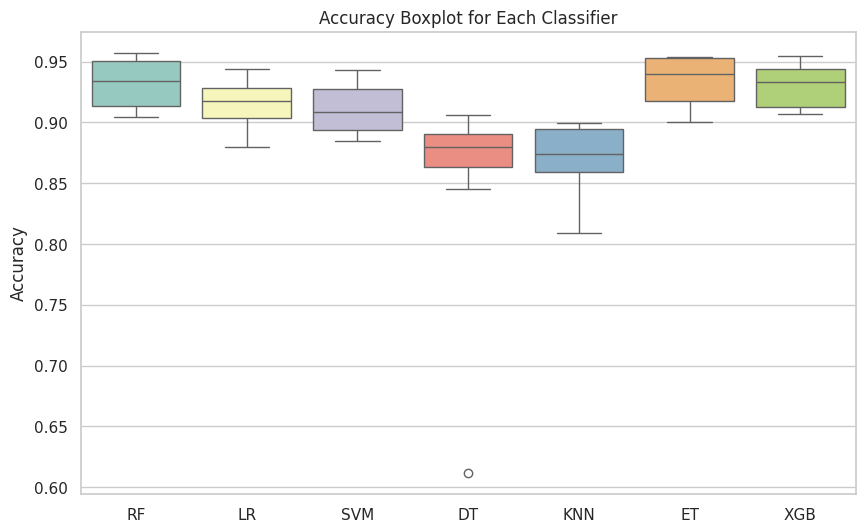

In [15]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a boxplot for each classifier
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_accuracy, palette="Set3")
plt.title('Accuracy Boxplot for Each Classifier')
plt.ylabel('Accuracy')
plt.show()

In [16]:
df_precision

,RF,LR,SVM,DT,KNN,ET,XGB
101,0.927205,0.922903,0.900847,0.875755,0.902267,0.928473,0.921672
102,0.935586,0.932941,0.926756,0.905780,0.895782,0.947880,0.935388
103,0.950246,0.926906,0.936736,0.905694,0.872714,0.953637,0.951151
104,0.909732,0.905945,0.898292,0.885714,0.881521,0.905276,0.909762
105,0.934125,0.924904,0.926717,0.885025,0.867613,0.935478,0.932652
106,0.905310,0.885006,0.887790,0.850494,0.863113,0.909958,0.914422
107,0.955064,0.947373,0.946932,0.869139,0.898451,0.955889,0.955490
108,0.957712,0.898758,0.897808,0.709090,0.826995,0.953149,0.942847


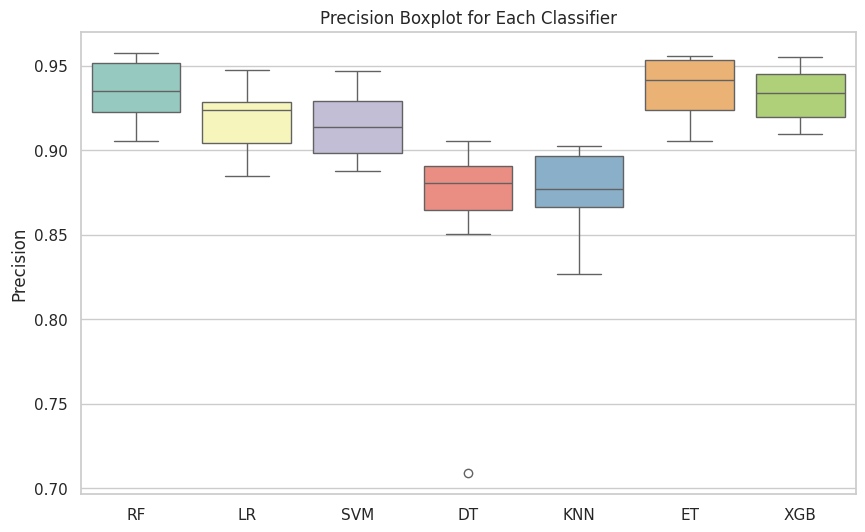

In [17]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a boxplot for each classifier
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_precision, palette="Set3")
plt.title('Precision Boxplot for Each Classifier')
plt.ylabel('Precision')
plt.show()

In [18]:
df_recall

,RF,LR,SVM,DT,KNN,ET,XGB
101,0.915865,0.911058,0.892628,0.873397,0.899840,0.919872,0.908654
102,0.935361,0.932319,0.924715,0.905703,0.893536,0.947529,0.934601
103,0.949425,0.926437,0.936782,0.905747,0.858621,0.952874,0.950575
104,0.904844,0.905709,0.896194,0.885813,0.881488,0.900519,0.906574
105,0.932403,0.923586,0.920647,0.885378,0.867010,0.932403,0.932403
106,0.904724,0.879904,0.884708,0.845476,0.859087,0.909528,0.914331
107,0.953528,0.944062,0.943201,0.869191,0.898451,0.953528,0.954389
108,0.957219,0.896868,0.894576,0.611917,0.809015,0.952636,0.941940


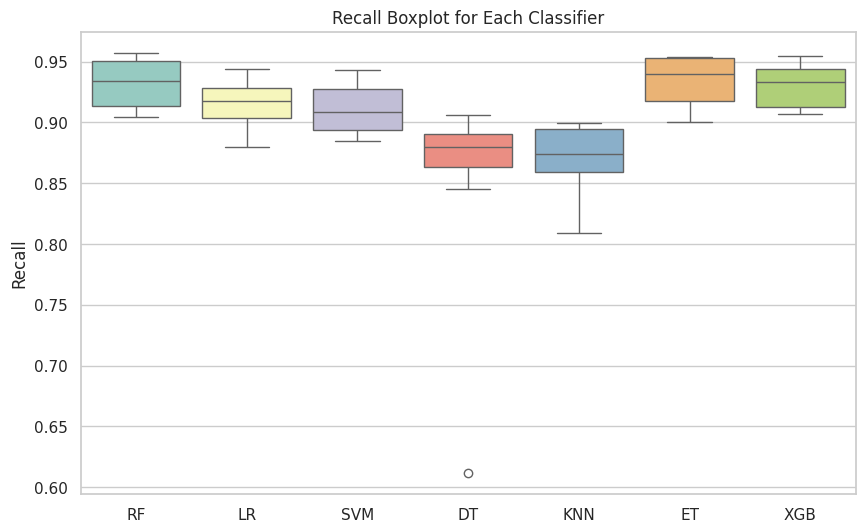

In [19]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a boxplot for each classifier
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_recall, palette="Set3")
plt.title('Recall Boxplot for Each Classifier')
plt.ylabel('Recall')
plt.show()

In [20]:
df_f1_score

,RF,LR,SVM,DT,KNN,ET,XGB
101,0.916857,0.912119,0.893744,0.874060,0.900409,0.920734,0.909773
102,0.935446,0.932504,0.925136,0.905739,0.894116,0.947635,0.934812
103,0.949208,0.926547,0.936727,0.905716,0.859281,0.952681,0.950395
104,0.905311,0.905794,0.896552,0.885434,0.881504,0.901002,0.906967
105,0.932735,0.923898,0.921359,0.885130,0.867253,0.932854,0.932494
106,0.904285,0.878227,0.883495,0.842994,0.857183,0.909166,0.914112
107,0.953731,0.944408,0.943571,0.868076,0.898451,0.953778,0.954557
108,0.957319,0.895577,0.892911,0.601003,0.798812,0.952746,0.942121


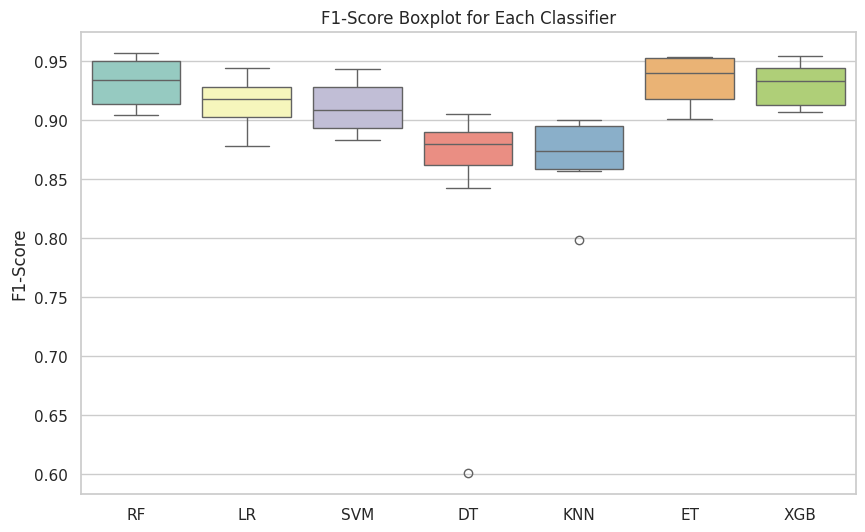

In [21]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a boxplot for each classifier
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_f1_score, palette="Set3")
plt.title('F1-Score Boxplot for Each Classifier')
plt.ylabel('F1-Score')
plt.show()

## Check Selected Algorith Classification Report

In [22]:
# subject 102 has all activities
cr_subject = 102

train_data = df[df['subjectID'] != cr_subject]
test_data = df[df['subjectID'] == cr_subject
               ]

X_train, y_train = fe.features_extract(df=train_data, accx='accx',
                                        accy='accy', accz='accz', activity='activityIndex',
                                        window_size=WINDOW_SIZE, step_size=STEP_SIZE)

X_test, y_test = fe.features_extract(df=test_data, accx='accx',
                                        accy='accy', accz='accz', activity='activityIndex',
                                        window_size=WINDOW_SIZE, step_size=STEP_SIZE)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

cr_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
cr_classifier.fit(X_train_scaled, y_train)

y_pred = cr_classifier.predict(X_test_scaled)

Classification Report

In [23]:
report_df = pd.DataFrame.from_dict(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df

,precision,recall,f1-score,support
0,0.909449,0.922156,0.915758,501.000000
1,0.951673,0.943489,0.947563,814.000000
accuracy,0.935361,0.935361,0.935361,0.935361
macro avg,0.930561,0.932822,0.931661,1315.000000
weighted avg,0.935586,0.935361,0.935446,1315.000000


Confusion Matrix

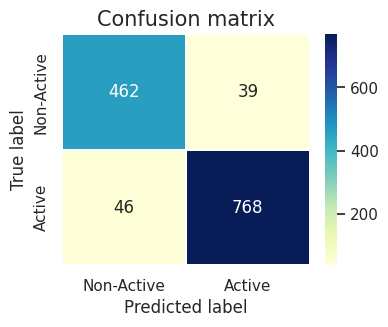

In [34]:
labels = ['Non-Active', 'Active']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))

sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')

plt.title('Confusion matrix', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Create Final RF Classifier and Export

Get All data for Training

In [25]:
X, y = fe.features_extract (df = df, accx = 'accx', 
                            accy = 'accy', accz = 'accz', activity = 'activityIndex', 
                            window_size = WINDOW_SIZE, step_size = STEP_SIZE)

print(X.shape, y.shape)

(9713, 112) (9713,)


Scaling

In [26]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

print(X_scaled.shape)

(9713, 112)


Random Forest Classifier

In [27]:
classifier_RF = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_RF.fit(X_scaled, y)
classifier_RF

RandomForestClassifier(random_state=42)

Export Prefered Model

In [28]:
joblib.dump(scaler, 'scaler_binary.pkl')
joblib.dump(classifier_RF, 'classifier_RF_binary.pkl')

['classifier_RF.pkl']